# Non-radial Orbit Correction


In this notebook we will explore the use of an orbit loop up table to correct the implied distance and velocity by relaxing the assumption of radial orbits a bit. We will use the implied distance and radial velocity to search in the precomputed orbits parameter space for the best matching orbit. This orbit will have a velocity vector that will not perfectly align with the galactocentric position vector, meaning that the cross product:

$$ \vec{R} \times \vec{V} = \vec{\Omega} \neq 0 $$

Where $\Omega$ is some non-zero vector that can be computed using the snapshot of the orbit that more closely matches the source. Then:

$$
\bigl(\vec{V}_0 + V_r \,\hat{n} + D \,\vec{\mu}\bigr) \times
\bigl(\vec{R}_0 + D \,\hat{n}\bigr) = \vec{\Omega}.
$$

Taking the dot product with $ \vec{\mu} $ to find the deviation in the velocity, we get:

$$
\vec{\mu} \cdot \Bigl(
\vec{V}_0 \times \vec{R}_0
+ D \, (\vec{V}_0 \times \hat{n})
- V_r \, (\vec{R}_0 \times \hat{n})
+ D \, (\vec{\mu} \times \vec{R}_0)
+ D^2 \, (\vec{\mu} \times \hat{n})
\Bigr)
= \vec{\mu} \cdot \vec{\Omega}.
$$

Which simplifies to:

$$
\vec{\mu} \cdot (\vec{V}_0 \times \vec{R}_0)
+ D \,\vec{\mu} \cdot (\vec{V}_0 \times \hat{n})
- V_r \,\vec{\mu} \cdot (\vec{R}_0 \times \hat{n})
= \vec{\mu} \cdot \vec{\Omega}.
$$

Solving for $ V_r $:

$$
V_r
= \frac{ \vec{\mu} \cdot (\vec{V}_0 \times \vec{R}_0)
+ D\,\vec{\mu} \cdot (\vec{V}_0 \times \hat{n})
- \vec{\mu} \cdot \vec{\Omega}
}{ \vec{\mu} \cdot (\vec{R}_0 \times \hat{n}) }.
$$

Therefore, if we call the purely radial solution $ \tilde{V}_r $, we get:

$$
V_r
= \tilde{V}_r
- \frac{\vec{\mu} \cdot \vec{\Omega}}{\vec{\mu} \cdot (\vec{R}_0 \times \hat{n})}.
$$

Similarly, taking the dot product with $ \hat{n} $ instead of $ \vec{\mu} $ to find the implied distance:

$$
\hat{n} \cdot \Bigl(
\vec{V}_0 \times \vec{R}_0
+ D \, (\vec{V}_0 \times \hat{n})
- V_r \, (\vec{R}_0 \times \hat{n})
+ D \, (\vec{\mu} \times \vec{R}_0)
+ D^2 \, (\vec{\mu} \times \hat{n})
\Bigr)
= \hat{n} \cdot \vec{\Omega}.
$$

Which simplifies to:

$$
(\hat{n} \times \vec{V}_0) \cdot \vec{R}_0
+ D \, \bigl((\hat{n} \times \vec{\mu}) \cdot \vec{R}_0\bigr)
= \hat{n} \cdot \vec{\Omega}.
$$

Solving for $ D $:

$$
D
= \frac{\hat{n} \cdot \vec{\Omega}
+ \hat{n} \cdot (\vec{R}_0 \times \vec{V}_0)}
{ \vec{R}_0 \cdot \bigl(\hat{n} \times \vec{\mu}\bigr)}.
$$

Again, calling the radial solution $ \tilde{D}_I $, we get:

$$
D
= \tilde{D}_I
+ \frac{\hat{n} \cdot \vec{\Omega}}
{ \vec{R}_0 \cdot \bigl(\hat{n} \times \vec{\mu}\bigr)}.
$$

Therefore, the correction to be applied if the trajectory is not strictly radial (given that $ \vec{\Omega} $ is known --- for example, from a lookup table of orbits that reach the current position with a total velocity similar to the source of interest) is as follows. One computes $ \vec{\Omega} $ for the realistic velocity vector, and then applies:

$$
D
= \tilde{D}_I
+ \frac{\hat{n} \cdot \vec{\Omega}}{\vec{R}_0 \cdot (\hat{n} \times \vec{\mu})},
\quad
V_r
= \tilde{V}_r
- \frac{\vec{\mu} \cdot \vec{\Omega}}{\vec{\mu} \cdot (\vec{R}_0 \times \hat{n})}.
$$

Note that if the deviation from a radial orbit is small (1st order perturbation) and given by a small angle $ \delta \alpha $, we will have:

$$
|\vec{\Omega}| = |\vec{R}||\vec{V}|\sin(\delta \alpha) \approx |\vec{R}||\vec{V}| \delta \alpha
$$


## Constructing orbital grid

We will precompute the orbit and then implement some search method to identify the orbit that crosses through the source and more closely aligns with the velocity. 

To reduce the parameter space we will use a potential that does not include a bar, and is therefore axisymmetric. This means that we only need to consider a single angle on a single cuadrant to include all the possible configurations. 

We know that the deviation from no radial orbits will be significant for ejection velocities smaller than about 1500km/s, while also it is not very interesting to look at ejection velocities below the Milky Way bulge escape velocity which is of about 800 km/s. 

In [6]:
# imports
import agama
import numpy as np
from astropy.coordinates import SkyCoord, Galactocentric
from astropy import units as u
from tqdm import tqdm
import os
import sys
import pandas as pd
from astropy.table import Table
from matplotlib import pyplot as plt

# set current directory to /app/data so we can work with relative paths
os.chdir('/app/data/')

# Add the path to the 'scripts' folder directly
sys.path.append('/app/data/')

from scripts import orbit_integration_agama as oia

import agama
agama.setUnits(mass=1, length=1, velocity=1)


## Single orbit testing

I will start with a single orbit initialized at 3pc from Sag A*, following the procedure done to simulate hypervelocity stars with speedystar (Evans et al. 2022 ). The orbit will be integrated using (Kenyon et al. 2008) axisymmetric potential, which was also used to integrate HVS candidate orbits in Brown et al. 2015

In [6]:
# toy model, single orbit initialized at 3pc from the center (Sag A*)

potential = agama.Potential(file='Agama/brown2015.pot')  # I will use the same potential as Brown et al. 2015


In [14]:
r_i = 3  # initial radius in pc
v_ej = 300  # km/s
theta = np.radians(45)  # angle in degrees from the Z-axis (galactic north pole) perpendicular to the plane of the galaxy
phi = np.radians(0)  # angle in degrees from the X-axis to the projection of the orbit on the galactic plane  

# Convert spherical coordinates to Cartesian coordinates
x = r_i * np.sin(theta) * np.cos(phi)
y = r_i * np.sin(theta) * np.sin(phi)
z = r_i * np.cos(theta)

# Convert velocity components to Cartesian
vx = v_ej * np.sin(theta) * np.cos(phi)
vy = v_ej * np.sin(theta) * np.sin(phi)
vz = v_ej * np.cos(theta)

# Define the initial state
initial_state = np.array([x, y, z, vx, vy, vz] ) # Position in pc and velocity in km/s

# Time settings for orbit integration
t_max = (300 * u.kpc / (v_ej * u.km / u.s)).to(u.Gyr).value  # Convert to Gyr
t_step = 1e-3  # Integration step in Gyr

# Integrate orbit
orbit = agama.orbit(potential=potential, ic=initial_state, time=t_max, dtype = object)#, trajsize=int(t_max/t_step))

# Extract trajectory and velocities
trajectory = orbit(orbit)[:, :3]
velocities = orbit(orbit)[:, 3:]

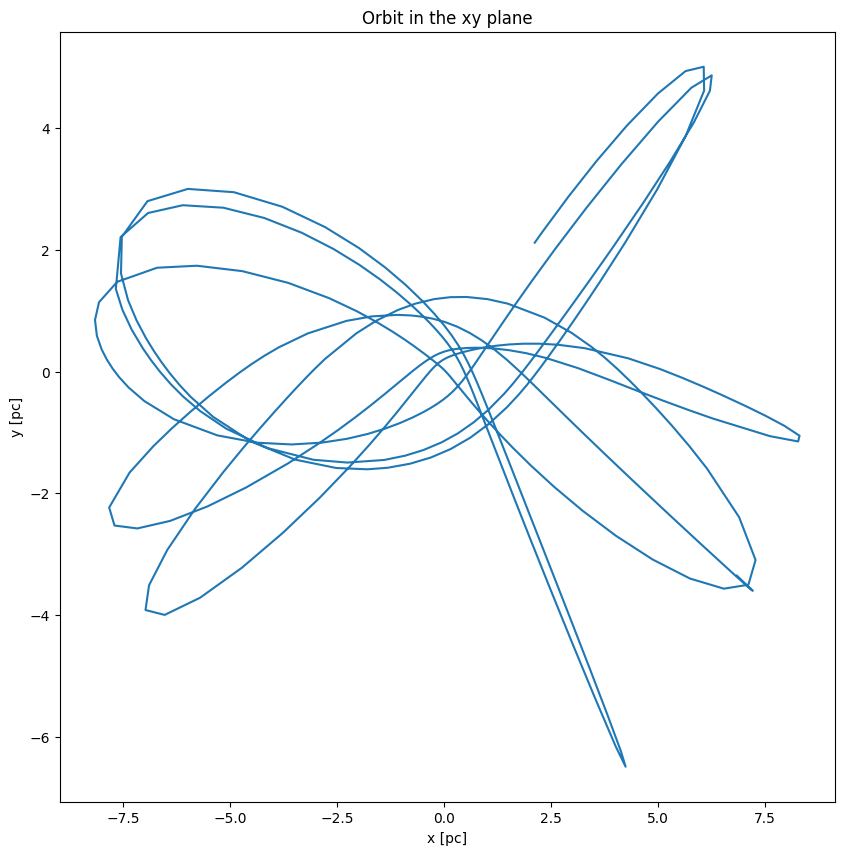

In [15]:
# orbit in the xz plane
plt.figure(figsize=(10, 10))
plt.plot(trajectory[:, 0], trajectory[:, 2])
plt.xlabel('x [pc]')
plt.ylabel('y [pc]')
plt.title('Orbit in the xy plane')
plt.show()

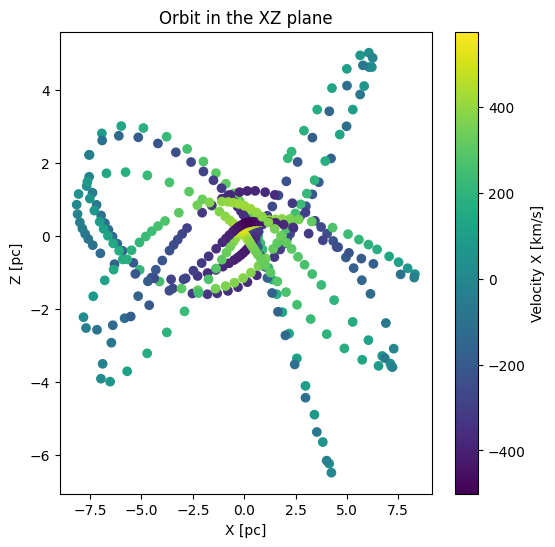

In [16]:
import matplotlib.pyplot as plt

# Normalize the velocity for colormap usage
velocity_x = velocities[:, 0]  # x-component of the velocity
norm = plt.Normalize(vmin=velocity_x.min(), vmax=velocity_x.max())

# Plot the orbit in the XZ plane
plt.figure(figsize=(6, 6))
scatter = plt.scatter(trajectory[:, 0], trajectory[:, 2], c=velocity_x, cmap='viridis', norm=norm)
plt.xlabel('X [pc]')
plt.ylabel('Z [pc]')
plt.title('Orbit in the XZ plane')

# Add a colorbar to indicate velocity scale
cbar = plt.colorbar(scatter)
cbar.set_label('Velocity X [km/s]')

plt.show()


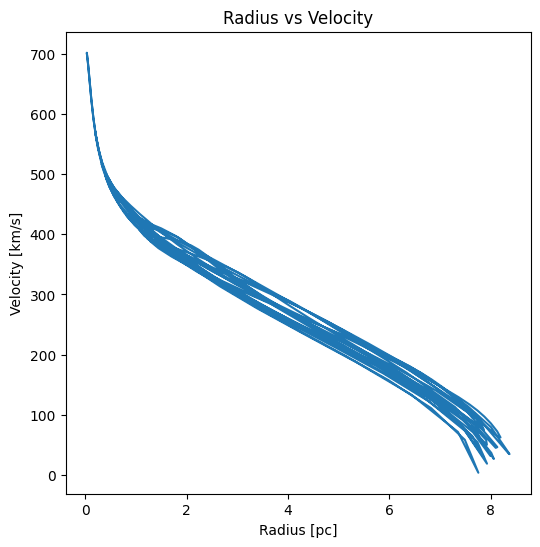

In [17]:
# plot radius vs velocity
r = np.sqrt(np.sum(trajectory**2, axis=1))
v = np.sqrt(np.sum(velocities**2, axis=1))

plt.figure(figsize=(6, 6))
plt.plot(r, v)
plt.xlabel('Radius [pc]')
plt.ylabel('Velocity [km/s]')
plt.title('Radius vs Velocity')
plt.show()

It is working, now I need a way to get only get the orbit before it turns back

In [93]:

def compute_orbit_to_apocenter(r_i, v_ej, theta_rad, phi_rad, potential_file='Agama/brown2015.pot', t_step=1e-3):
    """
    Compute the orbit trajectory and velocities up to the apocenter.

    Parameters:
        r_i (float): Initial radius in pc.
        v_ej (float): Ejection velocity in km/s.
        theta (float): Angle from the Z-axis in radians.
        phi (float): Angle from the X-axis to the projection in the galactic plane in radians.
        potential_file (str): Path to the potential file for the integration.
        t_step (float): Integration step in Gyr.

    Returns:
        tuple: Arrays of positions (x, y, z) and velocities (vx, vy, vz) up to the apocenter.
    """
    # Load the potential
    potential = agama.Potential(file=potential_file)
    
    # Convert spherical to Cartesian coordinates
    x = r_i * np.sin(theta_rad) * np.cos(phi_rad)
    y = r_i * np.sin(theta_rad) * np.sin(phi_rad)
    z = r_i * np.cos(theta_rad)
    vx = v_ej * np.sin(theta_rad) * np.cos(phi_rad)
    vy = v_ej * np.sin(theta_rad) * np.sin(phi_rad)
    vz = v_ej * np.cos(theta_rad)
    
    # Define the initial state
    initial_state = [x, y, z, vx, vy, vz]

    print(initial_state)
    
    # Integration settings
    t_max = (300 * u.kpc / (v_ej * u.km / u.s)).to(u.Gyr).value  # Convert max time to Gyr
    times = np.arange(0, t_max, t_step)
    
    # Integrate orbit
    orbit = agama.orbit(potential=potential, ic=initial_state, time=t_max, dtype = object)#, trajsize=int(t_max/t_step))

    # Extract trajectory and velocities
    positions = orbit(orbit)[:, :3]
    velocities = orbit(orbit)[:, 3:]

    # Find the apocenter
    radial_distances = np.linalg.norm(positions, axis=1)  # Compute radial distances
    apocenter_index = np.argmax(radial_distances)  # Find the index of the apocenter
    
    # Slice the results up to the apocenter
    positions_to_apocenter = positions[:apocenter_index + 1]
    velocities_to_apocenter = velocities[:apocenter_index + 1]
    
    return positions_to_apocenter, velocities_to_apocenter

def compute_orbit_to_first_apocenter(r_i, v_ej, theta_rad, phi_rad, potential_file='Agama/brown2015.pot', n_steps= None):
    """
    Compute the orbit trajectory and velocities up to the first apocenter.

    Parameters:
        r_i (float): Initial radius in pc.
        v_ej (float): Ejection velocity in km/s.
        theta_rad (float): Angle from the Z-axis in radians.
        phi_rad (float): Angle from the X-axis to the projection in the galactic plane in radians.
        potential_file (str): Path to the potential file for the integration.
        t_step (float): Integration step in Gyr.

    Returns:
        tuple: Arrays of positions (x, y, z) and velocities (vx, vy, vz) up to the first apocenter.
    """
    # Load the potential
    potential = agama.Potential(file=potential_file)
    
    # Convert spherical to Cartesian coordinates
    x = r_i * np.sin(theta_rad) * np.cos(phi_rad)
    y = r_i * np.sin(theta_rad) * np.sin(phi_rad)
    z = r_i * np.cos(theta_rad)
    vx = v_ej * np.sin(theta_rad) * np.cos(phi_rad)
    vy = v_ej * np.sin(theta_rad) * np.sin(phi_rad)
    vz = v_ej * np.cos(theta_rad)
    
    # Define the initial state
    initial_state = np.array([x, y, z, vx, vy, vz])
    #print(initial_state)
    # check that inital state is an array of Nx6 of float values
    #assert isinstance(initial_state, np.ndarray), 'Initial state must be a numpy array'
    assert initial_state.shape == (6,), 'Initial state must have shape (6,)'
    if initial_state.dtype != np.float64:
        initial_state = initial_state.ravel()
    assert initial_state.dtype == np.float64, 'Initial state must be of type float64'
    
    # Integration settings
    t_max = (300 * u.kpc / (v_ej * u.km / u.s)).to(u.Gyr).value  
    # Max time is defined as the time it takes to
    #  reach the MW virial radius, in practice most objects will not get here but we can guarantee that
    #  all the orbit of interest will exist in this time. 
    
    # Integrate orbit
    # If n_steps is not None, set the trajectory size to n_steps
    if n_steps is not None:
        orbit = agama.orbit(potential=potential, ic=initial_state, time=t_max, dtype = object, trajsize=n_steps)
    # If not, let Agama decide the trajectory size automatically using adaptive step size
    else:
        orbit = agama.orbit(potential=potential, ic=initial_state, time=t_max, dtype = object)#, trajsize=int(t_max/t_step))

    # Extract trajectory and velocities
    positions = orbit(orbit)[:, :3]
    velocities = orbit(orbit)[:, 3:]

    # Compute radial distances
    radial_distances = np.linalg.norm(positions, axis=1)

    # Find the first apocenter
    for i in range(1, len(radial_distances) - 1):
        if radial_distances[i] > radial_distances[i - 1] and radial_distances[i] > radial_distances[i + 1]:
            apocenter_index = i
            break
    else:
        apocenter_index = len(radial_distances) - 1  # Default to the last point if no apocenter is found

    # Slice the results up to the first apocenter
    positions_to_first_apocenter = positions[:apocenter_index + 1]
    velocities_to_first_apocenter = velocities[:apocenter_index + 1]
    
    return positions_to_first_apocenter, velocities_to_first_apocenter, orbit


# Compute the orbit up to the first apocenter but using the Rperiapo(E, L) agama function


def compute_orbit_to_first_apocenter_2(r_i, v_ej, theta_rad, phi_rad, potential_file='Agama/brown2015.pot', n_steps= None):
    """
    Compute the orbit trajectory and velocities up to the first apocenter.

    Parameters:
        r_i (float): Initial radius in pc.
        v_ej (float): Ejection velocity in km/s.
        theta_rad (float): Angle from the Z-axis in radians.
        phi_rad (float): Angle from the X-axis to the projection in the galactic plane in radians.
        potential_file (str): Path to the potential file for the integration.
        t_step (float): Integration step in Gyr.

    Returns:
        tuple: Arrays of positions (x, y, z) and velocities (vx, vy, vz) up to the first apocenter.
    """
    # Load the potential
    potential = agama.Potential(file=potential_file)
    
    # Convert spherical to Cartesian coordinates
    x = r_i * np.sin(theta_rad) * np.cos(phi_rad)
    y = r_i * np.sin(theta_rad) * np.sin(phi_rad)
    z = r_i * np.cos(theta_rad)
    vx = v_ej * np.sin(theta_rad) * np.cos(phi_rad)
    vy = v_ej * np.sin(theta_rad) * np.sin(phi_rad)
    vz = v_ej * np.cos(theta_rad)
    
    # Define the initial state
    initial_state = [x, y, z, vx, vy, vz]
    
    # Compute energy and angular momentum
    E_i = potential.potential(x, y, z) + 0.5 * (vx**2 + vy**2 + vz**2)
    # Angular momentum will always be 0 for radial orbits
    L_i = 0

    print('Initial energy:', E_i)
    print('Initial angular momentum:', L_i)

    # Compute the apocenter using the Rperiapo function
    apocenter_raddi = potential.Rperiapo(E_i, L_i)

    print('Apocenter radius:', apocenter_raddi)
    print('Integration time to apocenter:', apocenter_raddi*u.kpc /( v_ej*u.km/u.s).to(u.kpc/u.Gyr), 'Gyr')

    # Integration settings
    t_max = (apocenter_raddi[1]*u.kpc /( v_ej*u.km/u.s).to(u.pc/u.Gyr)).value
    # Max time is defined as the time it takes to
    #  reach the MW virial radius, in practice most objects will not get here but we can guarantee that
    #  all the orbit of interest will exist in this time. 
    
    # Integrate orbit
    # If n_steps is not None, set the trajectory size to n_steps
    if n_steps is not None:
        orbit = agama.orbit(potential=potential, ic=initial_state, time=t_max, dtype = object, trajsize=n_steps)
    # If not, let Agama decide the trajectory size automatically using adaptive step size
    else:
        orbit = agama.orbit(potential=potential, ic=initial_state, time=t_max, dtype = object)#, trajsize=int(t_max/t_step))

    # Extract trajectory and velocities
    positions = orbit(orbit)[:, :3]
    velocities = orbit(orbit)[:, 3:]

    # Compute radial distances
    radial_distances = np.linalg.norm(positions, axis=1)

    # Find the first apocenter
    for i in range(1, len(radial_distances) - 1):
        if radial_distances[i] > radial_distances[i - 1] and radial_distances[i] > radial_distances[i + 1]:
            apocenter_index = i
            break
    else:
        apocenter_index = len(radial_distances) - 1  # Default to the last point if no apocenter is found

    # Slice the results up to the first apocenter
    positions_to_first_apocenter = positions[:apocenter_index + 1]
    velocities_to_first_apocenter = velocities[:apocenter_index + 1]
    
    return positions_to_first_apocenter, velocities_to_first_apocenter, orbit

In [65]:
r_i = 3  # initial radius in pc
v_ej = 300  # km/s
theta = np.radians(45)  # angle in degrees from the Z-axis (galactic north pole) perpendicular to the plane of the galaxy
phi = np.radians(0)  # angle in degrees from the X-axis to the projection of the orbit on the galactic plane  

postions_to_apocenter, velocities_to_apocenter, orbit_interpolator = compute_orbit_to_first_apocenter(r_i, v_ej, theta,
                                                                                                       phi, n_steps=1000)

[  2.12132034   0.           2.12132034 212.13203436   0.
 212.13203436]


In [66]:
# r_i = 3  # initial radius in pc
# v_ej = 300  # km/s
# theta = np.radians(45)  # angle in degrees from the Z-axis (galactic north pole) perpendicular to the plane of the galaxy
# phi = np.radians(0)  # angle in degrees from the X-axis to the projection of the orbit on the galactic plane  

# postions_to_apocenter, velocities_to_apocenter, orbit_interpolator = compute_orbit_to_first_apocenter_2(r_i, v_ej,
#                                                                                                          theta, phi,
#                                                                                                            n_steps=1000)

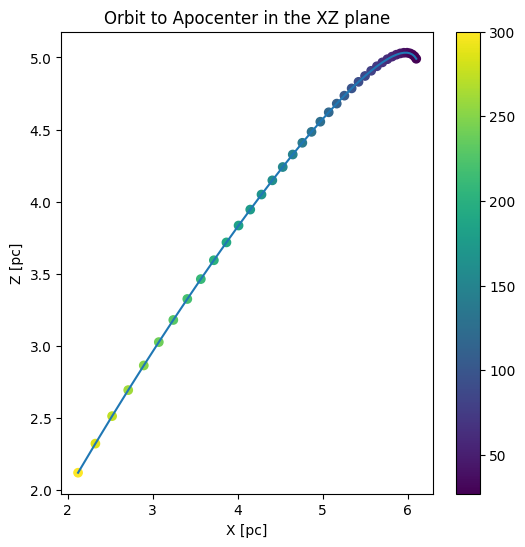

In [67]:
velocity_r = np.sqrt(np.sum(velocities_to_apocenter**2, axis=1))
plt.figure(figsize=(6, 6))
plt.plot(postions_to_apocenter[:, 0], postions_to_apocenter[:, 2])
plt.scatter(postions_to_apocenter[:, 0], postions_to_apocenter[:, 2], c=velocity_r, label='Start')
plt.colorbar()
plt.xlabel('X [pc]')
plt.ylabel('Z [pc]')
plt.title('Orbit to Apocenter in the XZ plane')
plt.show()

In [68]:
# Now for any given final condition we need an orbit that:
# 1. Intersects the final condition before the apocenter 
# 2. Has a total velocity that is similar to the final condition

import numpy as np
from scipy.optimize import minimize


def get_initial_velocity(r_f, theta_f, v_f, phi_rad=0, potential_file='Agama/brown2015.pot'):
    """
    Use conservation of energy to find the initial velocity
    """
    # Load the potential
    potential = agama.Potential(file=potential_file)

    # Convert the desired final condition to Cartesian
    x_f = r_f * np.sin(theta_f) * np.cos(phi_rad)
    y_f = r_f * np.sin(theta_f) * np.sin(phi_rad)
    z_f = r_f * np.cos(theta_f)

    vx_f = v_f * np.sin(theta_f) * np.cos(phi_rad)
    vy_f = v_f * np.sin(theta_f) * np.sin(phi_rad)
    vz_f = v_f * np.cos(theta_f)

    # Compute the energy at the final position
    Energy = potential.potential(x, y, z) + 0.5 * (vx**2 + vy**2 + vz**2)

    # Compute the initial velocity using conservation of energy
    v_i = np.sqrt(2 * (Energy - potential.potential(0, 0, 3)))

    return v_i


In [73]:
import numpy as np
from scipy.optimize import minimize



def objective_theta(theta_i, v_i, r_f, theta_f, v_f, phi_rad=0, potential_file='Agama/brown2015.pot'):
    """
    Objective function that computes the minimum mismatch between the orbit
    and the desired final conditions (r_f, theta_f, v_f) at any point.

    Now we only optimize over theta_i, while v_i is fixed (from energy).
    """
    r_i = 3.0  # pc (fixed)

    # Integrate the orbit from the initial conditions (r_i, v_i, theta_i)
    positions, velocities, _ = compute_orbit_to_first_apocenter( r_i=r_i, v_ej=v_i,
                                                                theta_rad=theta_i,
                                                                phi_rad=phi_rad,
                                                                potential_file=potential_file,
                                                                n_steps=1000
    )

    # Convert the desired final condition to Cartesian
    x_f = r_f * np.sin(theta_f) * np.cos(phi_rad)
    y_f = r_f * np.sin(theta_f) * np.sin(phi_rad)
    z_f = r_f * np.cos(theta_f)

    vx_f = v_f * np.sin(theta_f) * np.cos(phi_rad)
    vy_f = v_f * np.sin(theta_f) * np.sin(phi_rad)
    vz_f = v_f * np.cos(theta_f)

    target_pos = np.array([x_f, y_f, z_f])
    target_vel = np.array([vx_f, vy_f, vz_f])

    # For each point in the orbit, compute mismatch in position + velocity
    min_mismatch = np.inf
    for pos, vel in zip(positions, velocities):
        dpos = np.linalg.norm(pos - target_pos)
        dvel = np.linalg.norm(vel - target_vel)
        mismatch = dpos + dvel
        if mismatch < min_mismatch:
            min_mismatch = mismatch

    return min_mismatch


def find_initial_conditions(r_f, theta_f, v_f, phi_rad=0, potential_file='Agama/brown2015.pot'):
    """
    1) Compute the initial velocity v_i using conservation of energy.
    2) Optimize only over theta_i in [0, pi] to minimize the mismatch.
    3) Return (v_i, theta_i_opt).
    """
    # 1) Compute initial velocity from energy conservation
    v_i = get_initial_velocity(r_f, theta_f, v_f, phi_rad, potential_file)

    # 2) Optimize only over theta_i
    #    Use the final angle as an initial guess or you can guess 0, etc.
    theta_guess = theta_f  
    bounds = [(0.0, np.pi/2)]

    def objective_wrapper(theta_trial):
        return objective_theta(theta_trial[0], v_i, r_f, theta_f, v_f,
                               phi_rad=phi_rad, potential_file=potential_file)

    result = minimize(objective_wrapper, x0=[theta_guess], bounds=bounds)

    if not result.success:
        raise RuntimeError("Optimization for theta_i did not converge.")

    theta_i_opt = result.x[0]

    # 3) Return the (already known) v_i and the optimized angle
    return v_i, theta_i_opt



In [74]:

r_f_example = 10.0         # pc
theta_f_example = np.pi/4  # rad
v_f_example = 200.0        # km/s

v_i_found, theta_i_found = find_initial_conditions( # compute_orbit_to_first_apocenter(r_i, v_ej, theta_rad, phi_rad,
    r_f_example,
    theta_f_example,
    v_f_example,
    phi_rad=0,
)

print(f"Optimized initial velocity = {v_i_found:.3f} km/s")
print(f"Optimized initial angle    = {theta_i_found:.3f} rad")


[  2.12132034   0.           2.12132034 203.39623946   0.
 203.39623946]
[  2.12132036   0.           2.12132032 203.39624149   0.
 203.39623742]
[  0.           0.           3.           0.           0.
 287.64572037]
[3.0000000e-08 0.0000000e+00 3.0000000e+00 2.8764572e-06 0.0000000e+00
 2.8764572e+02]
[  1.82935838   0.           2.37769803 175.40236942   0.
 227.978221  ]
[  1.8293584    0.           2.37769801 175.4023717    0.
 227.97821925]
[  1.97569855   0.           2.25756844 189.43374394   0.
 216.45996652]
[  1.97569857   0.           2.25756842 189.4337461    0.
 216.45996463]
[  1.97894724   0.           2.25472123 189.74523468   0.
 216.18697085]
[  1.97894726   0.           2.25472121 189.74523685   0.
 216.18696895]
[  1.97664924   0.           2.25673609 189.52489841   0.
 216.38015929]
[  1.97664926   0.           2.25673607 189.52490057   0.
 216.38015739]
[  1.9766496    0.           2.25673577 189.52493296   0.
 216.38012902]
[  1.97664963   0.           2.256735

[  1.99626782   0.           2.23940054 232.89791265   0.
 261.26339637]


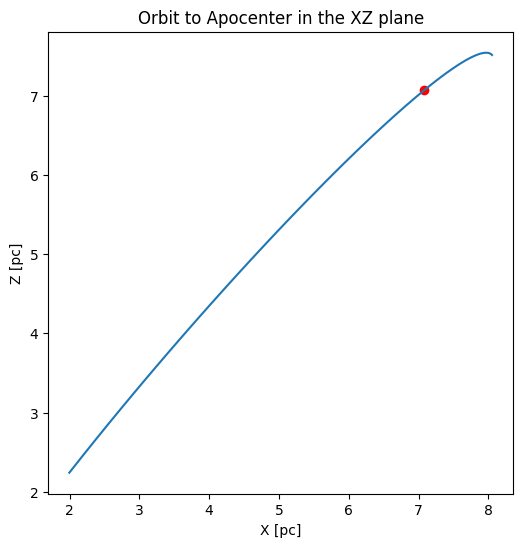

In [92]:
# compute the orbit with the optimized initial conditions
r_i = 3  # initial radius in pc
v_ej = 350#v_i_found  # km/s
theta = theta_i_found + np.radians(0.5)  # angle in degrees from the Z-axis (galactic north pole) perpendicular to the plane of the galaxy
phi = np.radians(0)  # angle in degrees from the X-axis to the projection of the orbit on the galactic plane

postions_to_apocenter, velocities_to_apocenter, orbit_interpolator = compute_orbit_to_first_apocenter(r_i, v_ej, theta, phi, n_steps=1000)

# convert example final conditions to Cartesian
x_f = r_f_example * np.sin(theta_f_example) * np.cos(phi)
y_f = r_f_example * np.sin(theta_f_example) * np.sin(phi)
z_f = r_f_example * np.cos(theta_f_example)


plt.figure(figsize=(6, 6))
plt.plot(postions_to_apocenter[:, 0], postions_to_apocenter[:, 2], label = 'Best fit Orbit')
plt.scatter(x_f, z_f, c='red', label='Source')
plt.xlabel('X [pc]')
plt.ylabel('Z [pc]')
plt.title('Orbit to Apocenter in the XZ plane')
plt.show()

# Finding both $V_ej$ and $\theta$

In [101]:
import numpy as np
from scipy.optimize import minimize

# We assume these two functions are already defined somewhere above:
# 1) get_initial_velocity(r_f, theta_f, v_f, phi_rad, potential_file)
# 2) compute_orbit_to_first_apocenter(r_i, v_ej, theta_rad, phi_rad, potential_file, n_steps=None)

def objective(params, r_f, theta_f, v_f, phi_rad=0, potential_file='Agama/brown2015.pot'):
    """
    Objective function that computes the minimum mismatch between the orbit
    and the desired final conditions (r_f, theta_f, v_f) at any point.
    
    Parameters
    ----------
    params : array-like
        [v_i, theta_i]
    r_f, theta_f, v_f : float
        Desired final conditions for the orbit.
    phi_rad : float
        Azimuthal angle in the galactic plane (fixed to 0 in your problem).
    potential_file : str
        Path to the Agama potential file.

    Returns
    -------
    mismatch : float
        The minimum mismatch (position + velocity) along the orbit.
    """
    v_i, theta_i = params
    r_i = 3.0  # pc (fixed initial radius)

    # Integrate the orbit from these initial conditions
    positions, velocities, _ = compute_orbit_to_first_apocenter(
        r_i=r_i,
        v_ej=v_i,
        theta_rad=theta_i,
        phi_rad=phi_rad,
        potential_file=potential_file,
        n_steps=1000
    )

    # Convert the desired final condition to Cartesian
    x_f = r_f * np.sin(theta_f) * np.cos(phi_rad)
    y_f = r_f * np.sin(theta_f) * np.sin(phi_rad)
    z_f = r_f * np.cos(theta_f)

    vx_f = v_f * np.sin(theta_f) * np.cos(phi_rad)
    vy_f = v_f * np.sin(theta_f) * np.sin(phi_rad)
    vz_f = v_f * np.cos(theta_f)

    target_pos = np.array([x_f, y_f, z_f])
    target_vel = np.array([vx_f, vy_f, vz_f])

    # Find the minimum phase-space mismatch at any point in the orbit
    min_mismatch = np.inf
    for pos, vel in zip(positions, velocities):
        dpos = np.linalg.norm(pos - target_pos)
        dvel = np.linalg.norm(vel - target_vel)
        mismatch = dpos + dvel
        if mismatch < min_mismatch:
            min_mismatch = mismatch

    return min_mismatch

def find_initial_conditions(r_f, theta_f, v_f, phi_rad=0, potential_file='Agama/brown2015.pot'):
    """
    1) Use get_initial_velocity(...) as a starting guess for v_i.
    2) Optimize over both [v_i, theta_i] to minimize the mismatch with
       the desired final conditions (r_f, theta_f, v_f).

    Parameters
    ----------
    r_f : float
        Desired final radius in pc.
    theta_f : float
        Desired final angle from Z-axis in radians.
    v_f : float
        Desired final velocity magnitude in km/s.
    phi_rad : float, optional
        Azimuthal angle (rad). Default=0.
    potential_file : str, optional
        Path to the Agama potential file.

    Returns
    -------
    (v_i_opt, theta_i_opt) : tuple
        The optimized initial velocity (km/s) and polar angle (rad).
    """
    # 1) Compute a physically motivated guess for v_i using energy conservation
    v_i_guess = get_initial_velocity(r_f, theta_f, v_f, phi_rad, potential_file)

    # Use the final angle as a guess for theta_i
    theta_guess = theta_f
    initial_guess = [v_i_guess, theta_guess]

    # Bounds: 
    #  - v_i >= 0  (no upper bound => None)
    #  - theta_i in [0, pi/2] or [0, pi], depending on your problem domain.
    bounds = [(200, 1500), (0, np.pi/2)]

    # 2) Minimize the objective function over [v_i, theta_i]
    def objective_wrapper(params):
        return objective(params, r_f, theta_f, v_f, phi_rad, potential_file)

    result = minimize(
        objective_wrapper,
        x0=initial_guess,
        bounds=bounds
    )

    if not result.success:
        raise RuntimeError("Optimization for [v_i, theta_i] did not converge.")

    v_i_opt, theta_i_opt = result.x
    return v_i_opt, theta_i_opt


# Example usage (uncomment if you want to run a quick test):
r_f_example = 15.0
theta_f_example = np.pi / 4
v_f_example = 200.0
v_i_final, theta_i_final = find_initial_conditions(
    r_f_example, theta_f_example, v_f_example, phi_rad=0
)
print(f"Optimized initial velocity: {v_i_final:.3f} km/s")
print(f"Optimized initial angle:    {theta_i_final:.3f} rad")


Optimized initial velocity: 284.191 km/s
Optimized initial angle:    0.716 rad


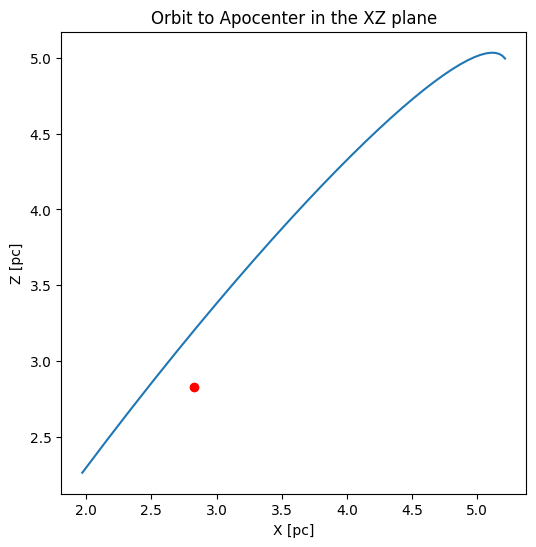

In [99]:
# compute the orbit with the optimized initial conditions
r_i = 3  # initial radius in pc
v_ej = 350#v_i_found  # km/s
theta = theta_i_found + np.radians(0.5)  # angle in degrees from the Z-axis (galactic north pole) perpendicular to the plane of the galaxy
phi = np.radians(0)  # angle in degrees from the X-axis to the projection of the orbit on the galactic plane

postions_to_apocenter, velocities_to_apocenter, orbit_interpolator = compute_orbit_to_first_apocenter(r_i, v_i_final, theta_i_final, 0, n_steps=1000)

# convert example final conditions to Cartesian
x_f = r_f_example * np.sin(theta_f_example) * np.cos(phi)
y_f = r_f_example * np.sin(theta_f_example) * np.sin(phi)
z_f = r_f_example * np.cos(theta_f_example)


plt.figure(figsize=(6, 6))
plt.plot(postions_to_apocenter[:, 0], postions_to_apocenter[:, 2], label = 'Best fit Orbit')
plt.scatter(x_f, z_f, c='red', label='Source')
plt.xlabel('X [pc]')
plt.ylabel('Z [pc]')
plt.title('Orbit to Apocenter in the XZ plane')
plt.show()

# Sergey Version

Using cilindrical coordinates we can express the velocity as a sum of $V_R$, $V_Z$ components, radial and z-component. Given a galactocentric latitud angle of ejection $\phi_{ej}$ the components of the velocity will be given by the orbit as a function of time and initial conditions:

$$ V_R(\phi_{ej}, V_{ej}, t) $$ 
$$ V_z(\phi_{ej}, V_{ej}, t) $$

This is just saying that they are a function of the position of the orbit, which is a function of time and initial conditions. Radius is also a function of time, so both functions can also be expressed as a function of radius. In the same way there is only one ejection angle that given an ejection velocity will give you the same orbit



In [42]:
import gala.potential as gp
import gala.integrate as gi
import gala.dynamics as gd
import astropy.units as auni
import astropy.coordinates as acoo
import numpy as np

pot = gp.MilkyWayPotential2022()
kms = auni.km / auni.s

acoo.galactocentric_frame_defaults.set('latest')


def doit(vej, cosang, t):
    #cosang = np.cos(ang)
    #sinang = np.sin(ang)
    sinang = np.sqrt(1 - cosang**2)
    startpos = np.array([cosang, 0, sinang]) * auni.kpc
    vel = np.array([cosang, 0, sinang]) * vej
    w0 = gd.PhaseSpacePosition(startpos, vel=vel * kms)
    nsteps = 1000
    timestep = t * auni.Myr / nsteps
    orbit = gp.Hamiltonian(pot).integrate_orbit(
        w0,
        dt=timestep,
        n_steps=nsteps,
        Integrator=gi.DOPRI853Integrator,
        # Integrator_kwargs = dict(atol=1e-15,rtol=1e-15)
    )
    R = (orbit.x**2 + orbit.z**2 + orbit.y**2)**.5
    z = orbit.z.to_value(auni.kpc)
    VR = orbit.v_x * R / orbit.x
    Vz = orbit.v_z - orbit.v_x * orbit.z / orbit.x
    return R.to_value(auni.kpc), z, VR.to_value(kms), Vz.to_value(kms)


def doall(N=10000, seed=3):
    rng = np.random.default_rng(seed)
    vej = 10**rng.uniform(2.4, 3.1, size=N)
    cosa = rng.uniform(0, 1, size=N)
    times = 10
    r1, r2, r3, r4 = [], [], [], []
    for curv, curc in tqdm(zip(vej, cosa), total=N):
        R, z, VR, Vz = doit(curv, curc, times)
        r1.append(R)
        r2.append(z)
        r3.append(VR)
        r4.append(Vz)

    return [np.array(_) for _ in [r1, r2, r3, r4]]


In [43]:
R, z, VR, Vz = doall(10000, 3)

100%|██████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:37<00:00, 264.35it/s]


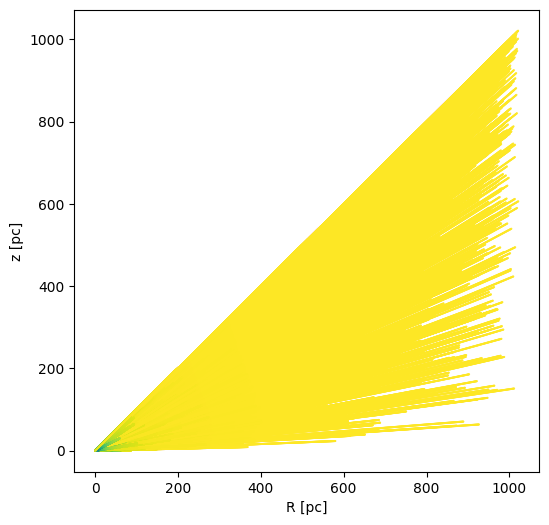

In [11]:
plt.figure(figsize=(6, 6))
plt.scatter(R, z, c=Vz, s = 0.2)
plt.xlabel('R [pc]')
plt.ylabel('z [pc]')
plt.show()

In [31]:
# select radius between 20 and 25 pc
mask = (R > 20) & (R < 25)
R_masked = R[mask]

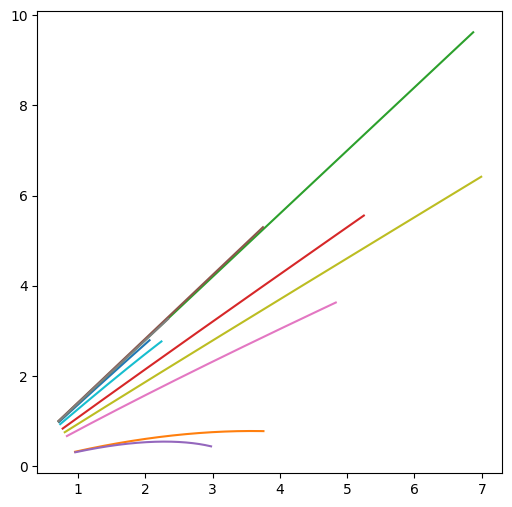

In [44]:
# plot a few of the orbits 

# transform cylindrical to cartesian
x = R * np.cos(np.arctan2(z, R))

plt.figure(figsize=(6, 6))
for i in range(0, 10):
    plt.plot(x[i], z[i])
#plt.plot(x[0], z[0])
plt.show()